# Comparação de Estratégias de Seleção de Instâncias em Aprendizado Ativo

## Imports

In [18]:
import pandas as pd
import numpy as np

## Reunindo Resultados para Comparação

In [1]:
RESULTS_DIR = '../../scripts/results/'

Por hora, seram analisados apenas as queries que utilizaram um determinado algoritmo (KNN) como aprendiz

## Gráfico de Ganho Acumulado

In [102]:
def gen_auc_df(file):
    auc_dict = dict()
    results = pd.read_csv(file)
    strategies = [c for c in results.columns if not 'choice' in c and not 'Unnamed' in c]
    
    for s in strategies:
        auc_dict[s] = [np.trapz(results[s][:i+1]) for i in range(len(results[s]))]
    auc_df = pd.DataFrame(auc_dict)
    
    return auc_df.sub(auc_df.random_meta_sampling, axis=0)

        

In [131]:
import time
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

def display_graph(df):
    df.plot.area(stacked=False, grid=True, figsize=(16, 6),
                     title=f'Ganho F1-macro X Query ({f}) [{i+1}/{len(result_files)}]',
                     style=([None]*9 + ['*-']) )
    
def display_all_graphs(learner_result_files):

    for i, f in enumerate(learner_result_files):
        auc_df = gen_auc_df(f)

        display_graph(auc_df)
        
        display(plt.gcf())
    
        input('Pressione Enter para continuar...')
    
        clear_output(wait=True)
        
        plt.close()

In [117]:
def summary_graph(learner_result_files):
    df_list = []
    for f in learner_result_files:
        df_list.append(gen_auc_df(f))

    return df_list

### KNN como Aprendiz

In [112]:
KNN = 'KNeighborsClassifier'

In [114]:
knn_results = !find $RESULTS_DIR -type f | grep $KNN

#### Ganho médio por query

<Axes: title={'center': 'Ganho Médio'}>

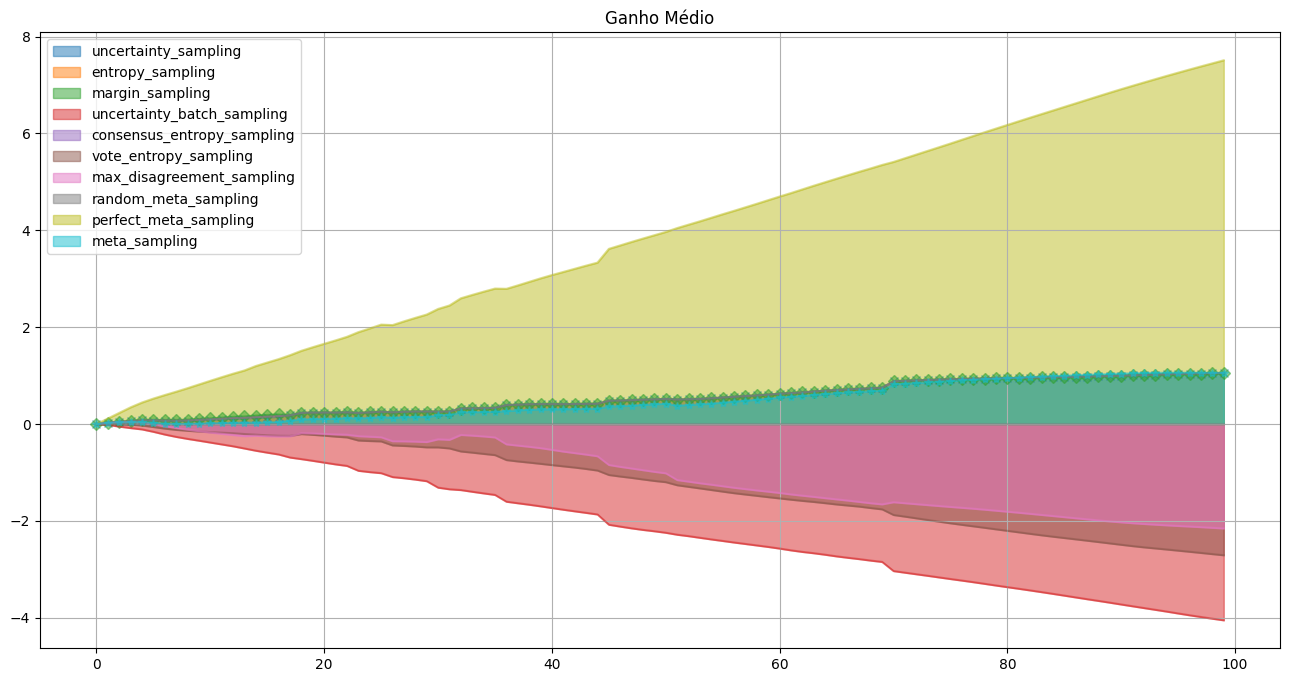

In [152]:
mean_dict, std_dict = dict(), dict()

g_list = summary_graph(knn_results)

strategies = g_list[0].columns

for s in strategies:
    df = pd.concat([e[s] for e in  g_list], axis=1)
    mean_dict[s] = df.mean(axis=1)
    std_dict[s] = df.std(axis=1)

styles = [None]*10
styles[9] = '*-'
styles[0] = 'x-' # uncertainty
styles[2] = 'D-' # margin

pd.DataFrame(mean_dict).plot.area(stacked=False, grid=True, figsize=(16,8), title="Ganho Médio",
                                  style=styles)

#### Gráficos Isolados

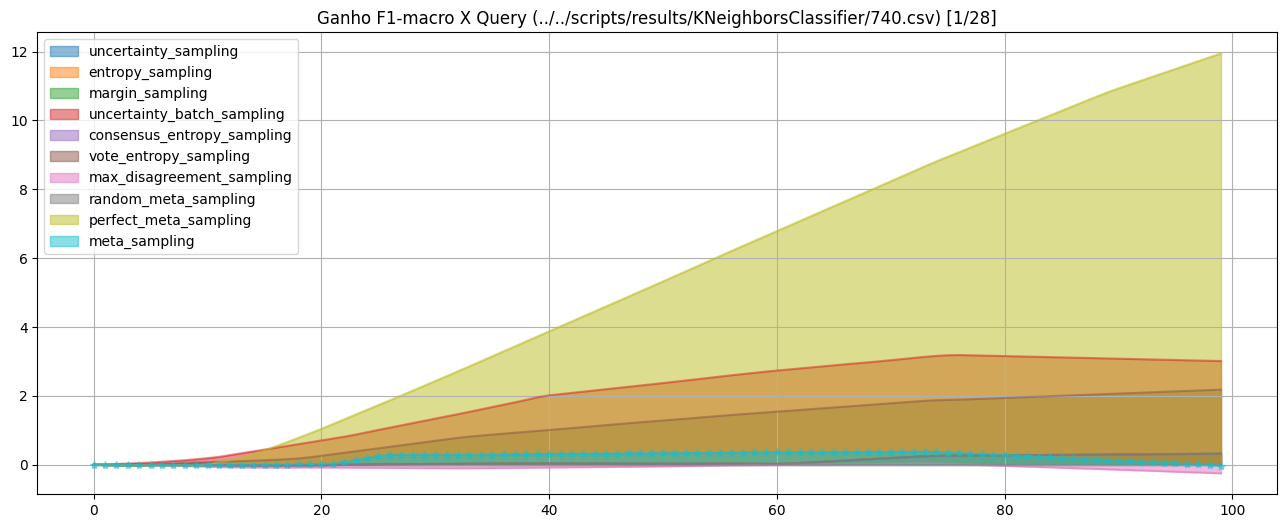

Pressione Enter para continuar... 


In [150]:
display_all_graphs(knn_results)

### Analisando Recomendações

In [173]:
pd.concat([pd.read_csv(f)for f in knn_results], axis=1)['meta_sampling_choice']

,meta_sampling_choice,meta_sampling_choice,meta_sampling_choice,meta_sampling_choice,meta_sampling_choice,meta_sampling_choice,meta_sampling_choice,meta_sampling_choice,meta_sampling_choice,meta_sampling_choice,...,meta_sampling_choice,meta_sampling_choice,meta_sampling_choice,meta_sampling_choice,meta_sampling_choice,meta_sampling_choice,meta_sampling_choice,meta_sampling_choice,meta_sampling_choice,meta_sampling_choice
0,uncertainty_sampling,max_disagreement_sampling,uncertainty_batch_sampling,margin_sampling,vote_entropy_sampling,uncertainty_batch_sampling,uncertainty_sampling,uncertainty_sampling,uncertainty_batch_sampling,uncertainty_batch_sampling,...,max_disagreement_sampling,max_disagreement_sampling,max_disagreement_sampling,consensus_entropy_sampling,uncertainty_sampling,uncertainty_sampling,uncertainty_sampling,uncertainty_sampling,margin_sampling,uncertainty_sampling
1,uncertainty_sampling,max_disagreement_sampling,uncertainty_batch_sampling,uncertainty_batch_sampling,vote_entropy_sampling,uncertainty_batch_sampling,uncertainty_sampling,uncertainty_sampling,uncertainty_batch_sampling,uncertainty_batch_sampling,...,max_disagreement_sampling,max_disagreement_sampling,max_disagreement_sampling,margin_sampling,uncertainty_sampling,uncertainty_sampling,uncertainty_sampling,uncertainty_sampling,margin_sampling,max_disagreement_sampling
2,uncertainty_sampling,max_disagreement_sampling,uncertainty_batch_sampling,uncertainty_batch_sampling,uncertainty_sampling,uncertainty_batch_sampling,uncertainty_sampling,max_disagreement_sampling,uncertainty_batch_sampling,uncertainty_batch_sampling,...,max_disagreement_sampling,max_disagreement_sampling,max_disagreement_sampling,margin_sampling,uncertainty_sampling,uncertainty_batch_sampling,uncertainty_sampling,uncertainty_sampling,margin_sampling,uncertainty_sampling
3,uncertainty_sampling,max_disagreement_sampling,uncertainty_batch_sampling,margin_sampling,uncertainty_sampling,uncertainty_batch_sampling,uncertainty_sampling,uncertainty_sampling,uncertainty_batch_sampling,uncertainty_batch_sampling,...,max_disagreement_sampling,max_disagreement_sampling,max_disagreement_sampling,uncertainty_batch_sampling,uncertainty_sampling,uncertainty_sampling,uncertainty_sampling,uncertainty_batch_sampling,margin_sampling,uncertainty_sampling
4,uncertainty_sampling,max_disagreement_sampling,uncertainty_batch_sampling,uncertainty_batch_sampling,uncertainty_sampling,uncertainty_batch_sampling,uncertainty_sampling,uncertainty_sampling,uncertainty_batch_sampling,uncertainty_batch_sampling,...,max_disagreement_sampling,max_disagreement_sampling,max_disagreement_sampling,margin_sampling,uncertainty_sampling,uncertainty_sampling,uncertainty_sampling,consensus_entropy_sampling,margin_sampling,uncertainty_sampling
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,uncertainty_sampling,NaN,max_disagreement_sampling,NaN,NaN,uncertainty_batch_sampling,uncertainty_sampling,vote_entropy_sampling,uncertainty_sampling,uncertainty_sampling,...,NaN,NaN,NaN,uncertainty_sampling,NaN,NaN,NaN,margin_sampling,NaN,uncertainty_sampling
96,uncertainty_sampling,NaN,max_disagreement_sampling,NaN,NaN,uncertainty_batch_sampling,uncertainty_sampling,vote_entropy_sampling,uncertainty_sampling,uncertainty_sampling,...,NaN,NaN,NaN,uncertainty_batch_sampling,NaN,NaN,NaN,margin_sampling,NaN,uncertainty_sampling
97,uncertainty_sampling,NaN,max_disagreement_sampling,NaN,NaN,uncertainty_batch_sampling,uncertainty_sampling,vote_entropy_sampling,uncertainty_sampling,uncertainty_sampling,...,NaN,NaN,NaN,uncertainty_sampling,NaN,NaN,NaN,uncertainty_sampling,NaN,uncertainty_sampling
98,uncertainty_sampling,NaN,max_disagreement_sampling,NaN,NaN,uncertainty_batch_sampling,uncertainty_sampling,vote_entropy_sampling,uncertainty_sampling,uncertainty_sampling,...,NaN,NaN,NaN,uncertainty_sampling,NaN,NaN,NaN,uncertainty_sampling,NaN,uncertainty_sampling
